In [2]:
import os
import glob
from copy import deepcopy
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, Dataset
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038 (from 1)
Receiving objects: 100% (6049/6049), 329.53 MiB | 15.07 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [4]:
# 68 keypoints of the face
# even columns: x-axis, odd columns: y-axis
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0


In [5]:
class FacesData(Dataset):
    def __init__(self, df):
      super(FacesData).__init__()
      self.df = df
      self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):
      img_path = "P1_Facial_Keypoints/data/training/" + self.df.iloc[idx, 0]
      img = cv2.imread(img_path) / 255.
      kp = deepcopy(self.df.iloc[idx, 1:].tolist())
      kp_x = (np.array(kp[0::2]) / img.shape[1]).tolist()
      kp_y = (np.array(kp[1::2]) / img.shape[0]).tolist()
      kp2 = kp_x + kp_y
      kp2 = torch.tensor(kp2)
      img = self.preprocess_input(img)
      return img, kp2

    def preprocess_input(self, img):
      img = cv2.resize(img, (224, 224))
      img = torch.tensor(img).permute(2, 0, 1)
      img = self.normalize(img).float()
      return img.to(device)

    def load_img(self, idx):
      img_path = "P1_Facial_Keypoints/data/training/" + self.df.iloc[idx, 0]
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
      img = cv2.resize(img, (224, 224))
      return img

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [17]:
def get_model():
  model = models.vgg16(pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.Sequential(
      nn.Conv2d(512, 512, 3),
      nn.MaxPool2d(2),
      nn.Flatten()
  )

  model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
  )

  criterion = nn.L1Loss()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  return model.to(device), criterion, optimizer

In [18]:
model, criterion, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
def train_batch(img, kps, model, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

In [12]:
@torch.no_grad()
def validate_batch(img, kps, model, criterion):
  model.eval()
  _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  return _kps, loss

In [19]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in tqdm(range(n_epochs), desc="Epochs"):
  epoch_train_loss, epoch_test_loss = 0, 0
  for idx, (img, kps) in enumerate(train_loader):
    loss = train_batch(img, kps, model, optimizer, criterion)
    epoch_train_loss += loss.item()
  epoch_train_loss /= (idx + 1)

  for idx, (img, kps) in enumerate(test_loader):
    ps, loss = validate_batch(img, kps, model, criterion)
    epoch_test_loss += loss.item()
  epoch_test_loss /= (idx + 1)

  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)

Epochs: 100%|██████████| 50/50 [27:43<00:00, 33.27s/it]


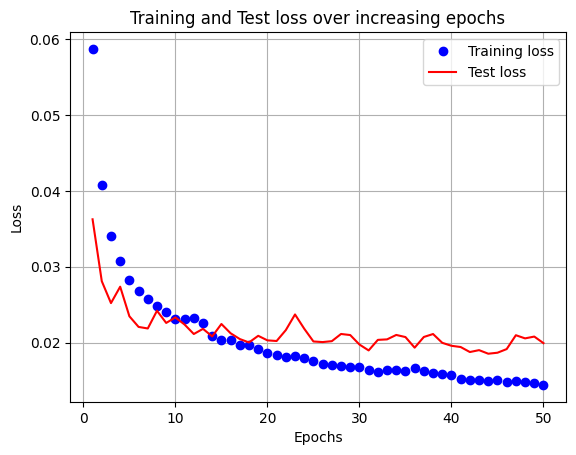

In [20]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

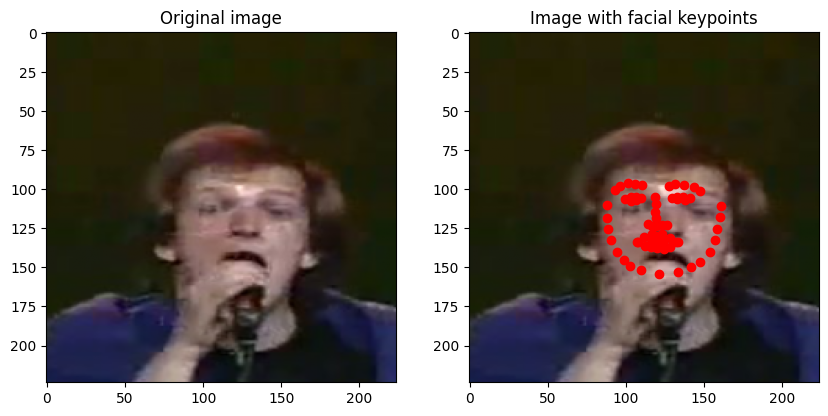

In [21]:
idx = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(idx)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[idx]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()